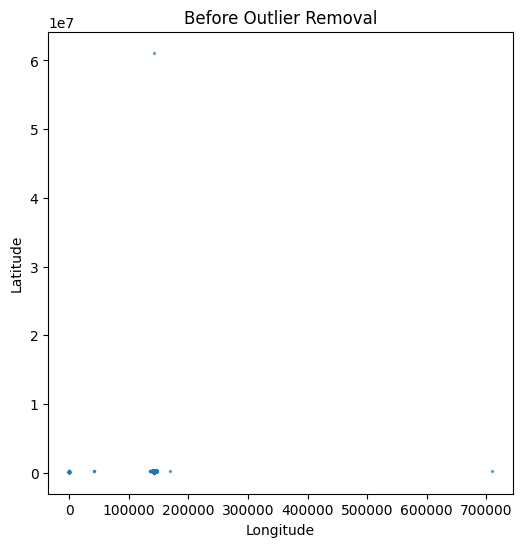

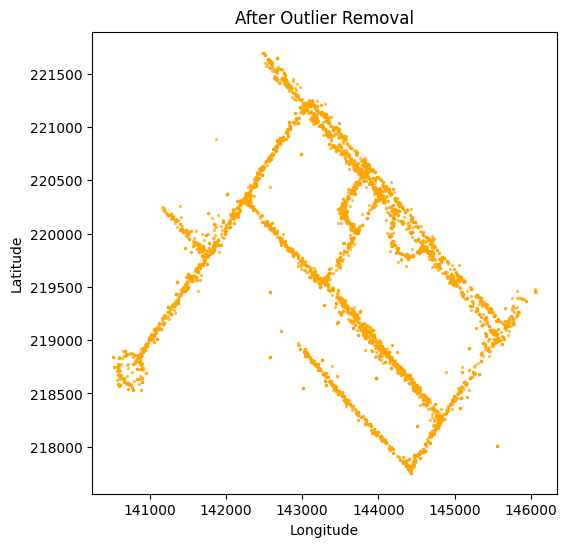

Original count: 6542
After removal: 6467


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the raw labels_train.csv
df = pd.read_csv('labels_train.csv')

# 1) Plot before cleaning
plt.figure(figsize=(6,6))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.6)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Before Outlier Removal')
plt.show()

# 2) IQR‐based outlier removal
Q1_lat, Q3_lat = df['latitude'].quantile([0.25, 0.75])
IQR_lat = Q3_lat - Q1_lat
Q1_lon, Q3_lon = df['longitude'].quantile([0.25, 0.75])
IQR_lon = Q3_lon - Q1_lon

mask = (
    df['latitude'].between(Q1_lat - 1.5*IQR_lat, Q3_lat + 1.5*IQR_lat) &
    df['longitude'].between(Q1_lon - 1.5*IQR_lon, Q3_lon + 1.5*IQR_lon)
)
df_clean = df[mask].reset_index(drop=True)

# Save cleaned CSV for later
df_clean.to_csv('labels_train_clean.csv', index=False)

# 3) Plot after cleaning
plt.figure(figsize=(6,6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], s=2, alpha=0.6, color='orange')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('After Outlier Removal')
plt.show()

# Print counts
print(f"Original count: {len(df)}")
print(f"After removal: {len(df_clean)}")


In [3]:
# Cell 2: Compute region-ID priors by inferring with best_model.pth

import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
import pandas as pd

# 2.1) Rebuild the classifier exactly as you trained it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load pretrained backbone
weights = EfficientNet_B0_Weights.IMAGENET1K_V1
clf = efficientnet_b0(weights=weights)

# replace its classifier with your two-layer head
num_ftrs = clf.classifier[1].in_features  # should be 1280
clf.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512,     256),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256,     15),
)

clf = clf.to(device)

# 2.2) Load the saved weights
clf.load_state_dict(torch.load("best_model.pth", map_location=device))
clf.eval()

# 2.3) Helper Dataset + DataLoader to run inference on any folder
transform_cls = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])
class SimpleImageDataset(Dataset):
    def __init__(self, df, folder, transform):
        self.df = df.reset_index(drop=True)
        self.folder = Path(folder)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        fname = self.df.loc[idx, "filename"]
        path  = self.folder / fname
        if not path.exists():
            # fallback .jpg ↔ .jpeg
            stem = Path(fname).stem
            matches = list(self.folder.glob(f"{stem}.*"))
            path = matches[0] if matches else path
        img = Image.open(path).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, idx

def compute_priors(df, folder):
    ds = SimpleImageDataset(df, folder, transform_cls)
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    priors = [None] * len(ds)
    with torch.no_grad():
        for imgs, idxs in dl:
            imgs = imgs.to(device)
            logits = clf(imgs)
            preds  = logits.argmax(dim=1).cpu().tolist()
            for i, di in enumerate(idxs.tolist()):
                priors[di] = preds[i]  # zero-based
    return priors

# 2.4) Run on cleaned train + val to produce your “region_prior” columns
df_train = pd.read_csv("labels_train_clean.csv")
train_priors = compute_priors(df_train, "images_train")
df_train["region_prior"] = [p+1 for p in train_priors]  # store 1–15

df_val = pd.read_csv("labels_val.csv")
val_priors = compute_priors(df_val, "images_val")
df_val["region_prior"] = [p+1 for p in val_priors]

# 2.5) Save out the new CSVs
df_train.to_csv("labels_train_with_prior.csv", index=False)
df_val.to_csv("labels_val_with_prior.csv",     index=False)


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import math
import pandas as pd
from torchvision import transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3.1) Dataset that returns (img, prior_idx, target_latlon, idx) so we can filter anomalies
class DirectionWithPriorDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform):
        self.df        = pd.read_csv(csv_file)
        self.img_dir   = Path(img_dir)
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        row      = self.df.iloc[i]
        fname    = row["filename"]
        p        = self.img_dir / fname
        if not p.exists():
            stem = Path(fname).stem
            matches = list(self.img_dir.glob(f"{stem}.*"))
            p = matches[0] if matches else p
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        prior = torch.tensor(int(row["region_prior"]) - 1, dtype=torch.long)
        lat   = float(row["latitude"])
        lon   = float(row["longitude"])
        target = torch.tensor([lat, lon], dtype=torch.float32)
        return img, prior, target, i

# 3.2) Transforms
train_trans = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3,0.3,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = DirectionWithPriorDataset("labels_train_with_prior.csv","images_train",train_trans)
val_ds   = DirectionWithPriorDataset("labels_val_with_prior.csv",  "images_val",  val_trans)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 3.3) Model definition
class LatLonModel(nn.Module):
    def __init__(self, num_regions=15, emb_dim=32):
        super().__init__()
        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_f     = backbone.classifier[1].in_features
        backbone.classifier = nn.Identity()
        self.backbone   = backbone
        self.region_emb = nn.Embedding(num_regions, emb_dim)
        self.head       = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_f+emb_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,     2)   # predict [lat, lon]
        )

    def forward(self, img, prior_idx):
        feat = self.backbone(img)
        emb  = self.region_emb(prior_idx)
        x    = torch.cat([feat, emb], dim=1)
        return self.head(x)

model = LatLonModel().to(DEVICE)

# 3.4) Initialize head bias to average lat, lon from cleaned train set
train_df = pd.read_csv("labels_train_clean.csv")
lat_mean, lon_mean = train_df["latitude"].mean(), train_df["longitude"].mean()
with torch.no_grad():
    # last layer is head[-1] → shape (2,)
    model.head[-1].bias.copy_(torch.tensor([lat_mean, lon_mean], device=DEVICE))


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from tqdm import tqdm

ANOMALIES = {95, 145, 146, 158, 159, 160, 161}

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=0.1)
criterion = nn.MSELoss(reduction='sum')  # sum of squared errors

best_val_mse = float('inf')
patience     = 5
no_improve   = 0

for epoch in range(1, 31):
    # — Train —
    model.train()
    train_se = 0.0
    for imgs, priors, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        imgs, priors, targets = imgs.to(DEVICE), priors.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs, priors)
        se  = criterion(out, targets)    # sum squared error for this batch
        se.backward(); optimizer.step()
        train_se += se.item()
    train_mse = train_se / len(train_ds)

    # — Validate (skip anomalies) —
    model.eval()
    val_se  = 0.0
    val_cnt = 0
    with torch.no_grad():
        for imgs, priors, targets, idxs in tqdm(val_loader, desc=f"Epoch {epoch} Val"):
            # mask out anomalies
            keep_mask = [(i not in ANOMALIES) for i in idxs.tolist()]
            if not any(keep_mask):
                continue
            # select only kept
            imgs    = imgs[keep_mask].to(DEVICE)
            priors  = priors[keep_mask].to(DEVICE)
            targets = targets[keep_mask].to(DEVICE)

            out = model(imgs, priors)
            se  = criterion(out, targets)
            val_se += se.item()
            val_cnt += imgs.size(0)

    val_mse = val_se / val_cnt

    scheduler.step()
    print(f"Epoch {epoch:02d}  "
          f"Train MSE={train_mse:.2f}  Val MSE={val_mse:.2f}")

    # early stopping on val MSE
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        no_improve   = 0
        torch.save(model.state_dict(), "best_latlon_model.pth")
        print("  ↳ New best — saved checkpoint.")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Stopping early.")
            break


Epoch 1 Val: 100%|██████████| 12/12 [00:01<00:00,  7.11it/s]


Epoch 01  Train MSE=708279.15  Val MSE=729117.70
  ↳ New best — saved checkpoint.


Epoch 2 Val: 100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


Epoch 02  Train MSE=679590.27  Val MSE=701151.32
  ↳ New best — saved checkpoint.


Epoch 3 Val: 100%|██████████| 12/12 [00:01<00:00,  8.30it/s]


Epoch 03  Train MSE=652756.95  Val MSE=692433.73
  ↳ New best — saved checkpoint.


Epoch 4 Val: 100%|██████████| 12/12 [00:01<00:00,  8.46it/s]


Epoch 04  Train MSE=612504.11  Val MSE=650026.02
  ↳ New best — saved checkpoint.


Epoch 5 Val: 100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 05  Train MSE=581050.49  Val MSE=599035.19
  ↳ New best — saved checkpoint.


Epoch 6 Val: 100%|██████████| 12/12 [00:01<00:00,  8.50it/s]


Epoch 06  Train MSE=553814.45  Val MSE=597167.83
  ↳ New best — saved checkpoint.


Epoch 7 Val: 100%|██████████| 12/12 [00:01<00:00,  8.09it/s]


Epoch 07  Train MSE=504435.33  Val MSE=534781.75
  ↳ New best — saved checkpoint.


Epoch 8 Val: 100%|██████████| 12/12 [00:01<00:00,  8.32it/s]


Epoch 08  Train MSE=449842.66  Val MSE=505490.50
  ↳ New best — saved checkpoint.


Epoch 9 Val: 100%|██████████| 12/12 [00:01<00:00,  8.12it/s]


Epoch 09  Train MSE=372764.38  Val MSE=372573.76
  ↳ New best — saved checkpoint.


Epoch 10 Val: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 10  Train MSE=319182.34  Val MSE=390952.10


Epoch 11 Val: 100%|██████████| 12/12 [00:01<00:00,  8.04it/s]


Epoch 11  Train MSE=280302.87  Val MSE=353349.86
  ↳ New best — saved checkpoint.


Epoch 12 Val: 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


Epoch 12  Train MSE=273578.21  Val MSE=379515.21


Epoch 13 Val: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]


Epoch 13  Train MSE=266841.75  Val MSE=341000.21
  ↳ New best — saved checkpoint.


Epoch 14 Val: 100%|██████████| 12/12 [00:01<00:00,  8.11it/s]


Epoch 14  Train MSE=265318.50  Val MSE=346031.71


Epoch 15 Val: 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 15  Train MSE=256040.83  Val MSE=330657.26
  ↳ New best — saved checkpoint.


Epoch 16 Val: 100%|██████████| 12/12 [00:01<00:00,  8.44it/s]


Epoch 16  Train MSE=252486.60  Val MSE=318310.72
  ↳ New best — saved checkpoint.


Epoch 17 Val: 100%|██████████| 12/12 [00:01<00:00,  8.38it/s]


Epoch 17  Train MSE=254682.11  Val MSE=331635.78


Epoch 18 Val: 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 18  Train MSE=246927.79  Val MSE=338434.72


Epoch 19 Val: 100%|██████████| 12/12 [00:01<00:00,  8.33it/s]


Epoch 19  Train MSE=247248.26  Val MSE=296416.43
  ↳ New best — saved checkpoint.


Epoch 20 Val: 100%|██████████| 12/12 [00:01<00:00,  8.66it/s]


Epoch 20  Train MSE=238014.89  Val MSE=305557.57


Epoch 21 Val: 100%|██████████| 12/12 [00:01<00:00,  8.20it/s]


Epoch 21  Train MSE=233339.89  Val MSE=303064.43


Epoch 22 Val: 100%|██████████| 12/12 [00:01<00:00,  8.67it/s]


Epoch 22  Train MSE=237089.95  Val MSE=351383.84


Epoch 23 Val: 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Epoch 23  Train MSE=235278.74  Val MSE=301896.22


Epoch 24 Val: 100%|██████████| 12/12 [00:01<00:00,  8.19it/s]

Epoch 24  Train MSE=234775.04  Val MSE=304916.08
Stopping early.


In [9]:
# Cell 6: Final inference on VAL + TEST, writing lat/lon CSV

import os, csv
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torchvision import transforms

# 6.0) Constants
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ANOMALIES = {95, 145, 146, 158, 159, 160, 161}
OVERRIDES = {
    525: (221626, 135367),
    528: (38336, 258),
    529: (38254, 145),
    530: (38312, 226),
}

# 6.1) Reload your classifier & lat/lon models
clf.load_state_dict(torch.load("best_model.pth",      map_location=DEVICE))
clf.eval()
model.load_state_dict(torch.load("best_latlon_model.pth", map_location=DEVICE))
model.eval()

# 6.2) Transforms (same as used during training/validation)
val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# 6.3) Simple dataset to yield (img_tensor, local_idx)
class SimpleImageDataset(Dataset):
    def __init__(self, df, folder, transform):
        self.transform = transform
        self.folder    = Path(folder)
        # if df is a DataFrame, pull filenames; else assume folder-only mode
        if isinstance(df, pd.DataFrame):
            self.fnames = df["filename"].tolist()
        else:
            # folder-only: list all image files
            suffixes = {'.jpg','.jpeg','.png','.bmp','.tif','.tiff'}
            files = sorted(os.listdir(folder))
            self.fnames = [f for f in files
                           if os.path.splitext(f)[1].lower() in suffixes]
        self.df_mode = isinstance(df, pd.DataFrame)

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path  = self.folder / fname
        if not path.exists():
            # fallback for .jpg/.jpeg mismatches
            stem = Path(fname).stem
            matches = list(self.folder.glob(f"{stem}.*"))
            if matches:
                path = matches[0]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, idx

# 6.4) Build VAL loader
df_val   = pd.read_csv("labels_val.csv")
val_ds   = SimpleImageDataset(df_val,   "images_val",  val_trans)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
n_val = len(val_ds)

# 6.5) Build TEST loader
test_ds   = SimpleImageDataset(None,     "images_test", val_trans)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 6.6) Inference + write CSV
out_path = "latlon_all_predictions.csv"
with open(out_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id","latitude","longitude"])

    # — VAL predictions (skip anomalies) —
    with torch.no_grad():
        for imgs, idxs in val_loader:
            imgs = imgs.to(DEVICE)
            # 1) predict region priors
            logits = clf(imgs)
            priors = logits.argmax(1).to(DEVICE)
            # 2) predict lat/lon
            outs   = model(imgs, priors).cpu().tolist()
            for local_idx, (lat, lon) in zip(idxs.tolist(), outs):
                if local_idx in ANOMALIES:
                    continue
                writer.writerow([local_idx, lat, lon])

    # — TEST predictions —
    with torch.no_grad():
        for imgs, idxs in test_loader:
            imgs = imgs.to(DEVICE)
            # predict priors
            logits = clf(imgs)
            priors = logits.argmax(1).to(DEVICE)
            # predict lat/lon
            outs   = model(imgs, priors).cpu().tolist()
            for local_idx, (lat, lon) in zip(idxs.tolist(), outs):
                global_id = n_val + local_idx
                if global_id in OVERRIDES:
                    lat, lon = OVERRIDES[global_id]
                writer.writerow([global_id, lat, lon])

print(f"Wrote combined lat/lon predictions to {out_path}")


Wrote combined lat/lon predictions to latlon_all_predictions.csv
